# 04. Margin Optimization Study

This notebook analyzes profit margins and pricing strategies to maximize profitability:
- **Margin analysis by product** - Which products are most/least profitable
- **Price elasticity** - Revenue vs margin trade-offs
- **Cost structure** - Understanding cost components and optimization opportunities
- **Pricing recommendations** - Data-driven pricing strategies
- **Margin improvement opportunities** - Quick wins and strategic actions

**Business Value**: Increase overall profitability through strategic pricing, cost reduction, and product mix optimization.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Define paths (relative to project root)
import os
DATA_PATH = '../../data/context_states/consolidated_analysis_20251022_173402/datasets/'

# Create output folder for this notebook
OUTPUT_DIR = '04_margin_optimization_study'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify data path exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data path not found: {DATA_PATH}\nCurrent directory: {os.getcwd()}")

print(f"✓ Data path verified: {DATA_PATH}")
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Data path verified: ../../data/context_states/consolidated_analysis_20251022_173402/datasets/
✓ Output directory: 04_margin_optimization_study


In [3]:
# Load datasets with correct date parsing
df_products = pd.read_csv(f'{DATA_PATH}product_daily_attrs.csv')
df_products['dt_date'] = pd.to_datetime(df_products['dt_date'], format='%Y%m%d')

df_daily = pd.read_csv(f'{DATA_PATH}daily_attrs.csv')
df_daily['dt_date'] = pd.to_datetime(df_daily['dt_date'], format='%Y%m%d')

# Load transaction-level data for price analysis
df_trans = pd.read_csv(f'{DATA_PATH}transactions_enriched.csv')
df_trans['dt_date'] = pd.to_datetime(df_trans['in_dt'])

print(f"✓ Loaded product_daily_attrs.csv: {len(df_products)} rows")
print(f"✓ Loaded daily_attrs.csv: {len(df_daily)} rows")
print(f"✓ Loaded transactions_enriched.csv: {len(df_trans)} rows")
print(f"\nDate range: {df_products['dt_date'].min().strftime('%Y-%m-%d')} to {df_products['dt_date'].max().strftime('%Y-%m-%d')}")
print(f"Products analyzed: {df_products['in_product_id'].nunique()} unique products")

✓ Loaded product_daily_attrs.csv: 266 rows
✓ Loaded daily_attrs.csv: 30 rows
✓ Loaded transactions_enriched.csv: 609 rows

Date range: 2025-10-01 to 2025-10-30
Products analyzed: 10 unique products


In [4]:
# Define color scheme
COLORS = {
    'primary': '#2E86AB',
    'success': '#06A77D',
    'warning': '#F77F00',
    'danger': '#D62828',
    'secondary': '#6C757D',
    'info': '#17A2B8',
    'purple': '#6F42C1',
    'teal': '#20C997'
}

## 1. Product Margin Analysis

Calculating and analyzing profit margins for each product:
- Gross margin percentage
- Absolute profit contribution
- Margin vs volume trade-offs

In [5]:
# Aggregate product-level metrics
product_summary = df_products.groupby('in_product_id').agg({
    'price_total_sum': 'sum',
    'cost_total_sum': 'sum',
    'quantity_sum': 'sum',
    'trans_id_count': 'sum',
    'customer_id_count': 'sum'
}).reset_index()

product_summary.columns = ['product_id', 'total_revenue', 'total_cost', 'units_sold', 'transactions', 'unique_customers']

# Calculate margin metrics
product_summary['profit'] = product_summary['total_revenue'] - product_summary['total_cost']
product_summary['margin_pct'] = (product_summary['profit'] / product_summary['total_revenue']) * 100
product_summary['avg_price'] = product_summary['total_revenue'] / product_summary['units_sold']
product_summary['avg_cost'] = product_summary['total_cost'] / product_summary['units_sold']
product_summary['revenue_pct'] = (product_summary['total_revenue'] / product_summary['total_revenue'].sum()) * 100
product_summary['profit_pct'] = (product_summary['profit'] / product_summary['profit'].sum()) * 100

# Sort by profit
product_summary = product_summary.sort_values('profit', ascending=False).reset_index(drop=True)

print("Product Margin Summary:")
print("=" * 100)
print(f"{'Product':<12} {'Revenue':<15} {'Cost':<15} {'Profit':<15} {'Margin %':<10} {'Units':<10}")
print("=" * 100)
for idx, row in product_summary.iterrows():
    print(f"{row['product_id']:<12} ${row['total_revenue']:>12,.0f} ${row['total_cost']:>12,.0f} ${row['profit']:>12,.0f} {row['margin_pct']:>8.1f}% {row['units_sold']:>8.0f}")

# Calculate portfolio metrics
total_revenue = product_summary['total_revenue'].sum()
total_cost = product_summary['total_cost'].sum()
total_profit = product_summary['profit'].sum()
portfolio_margin = (total_profit / total_revenue) * 100

print("\n" + "=" * 100)
print(f"{'PORTFOLIO TOTAL':<12} ${total_revenue:>12,.0f} ${total_cost:>12,.0f} ${total_profit:>12,.0f} {portfolio_margin:>8.1f}%")
print("=" * 100)

# Find margin leaders and laggards
best_margin_product = product_summary.loc[product_summary['margin_pct'].idxmax()]
worst_margin_product = product_summary.loc[product_summary['margin_pct'].idxmin()]
most_profitable_product = product_summary.iloc[0]  # Already sorted by profit

print(f"\n📊 KEY INSIGHTS:")
print(f"   • Portfolio margin: {portfolio_margin:.1f}%")
print(f"   • Best margin: {best_margin_product['product_id']} ({best_margin_product['margin_pct']:.1f}%)")
print(f"   • Worst margin: {worst_margin_product['product_id']} ({worst_margin_product['margin_pct']:.1f}%)")
print(f"   • Most profitable: {most_profitable_product['product_id']} (${most_profitable_product['profit']:,.0f} total profit)")

Product Margin Summary:
Product      Revenue         Cost            Profit          Margin %   Units     
prod7        $   8,161,219 $   5,087,637 $   3,073,582     37.7%      248
prod10       $   9,887,466 $   7,539,292 $   2,348,174     23.7%      279
prod8        $   7,487,707 $   5,411,102 $   2,076,605     27.7%      291
prod4        $   5,075,329 $   3,274,151 $   1,801,178     35.5%      192
prod6        $   4,342,449 $   2,812,387 $   1,530,062     35.2%      217
prod2        $   4,181,925 $   2,736,423 $   1,445,502     34.6%      227
prod3        $   4,276,070 $   2,930,176 $   1,345,894     31.5%      190
prod5        $   3,975,302 $   2,810,910 $   1,164,392     29.3%      250
prod9        $   3,502,255 $   2,425,046 $   1,077,209     30.8%      254
prod1        $   2,606,098 $   1,863,347 $     742,751     28.5%      199

PORTFOLIO TOTAL $  53,495,820 $  36,890,471 $  16,605,349     31.0%

📊 KEY INSIGHTS:
   • Portfolio margin: 31.0%
   • Best margin: prod7 (37.7%)
   • W

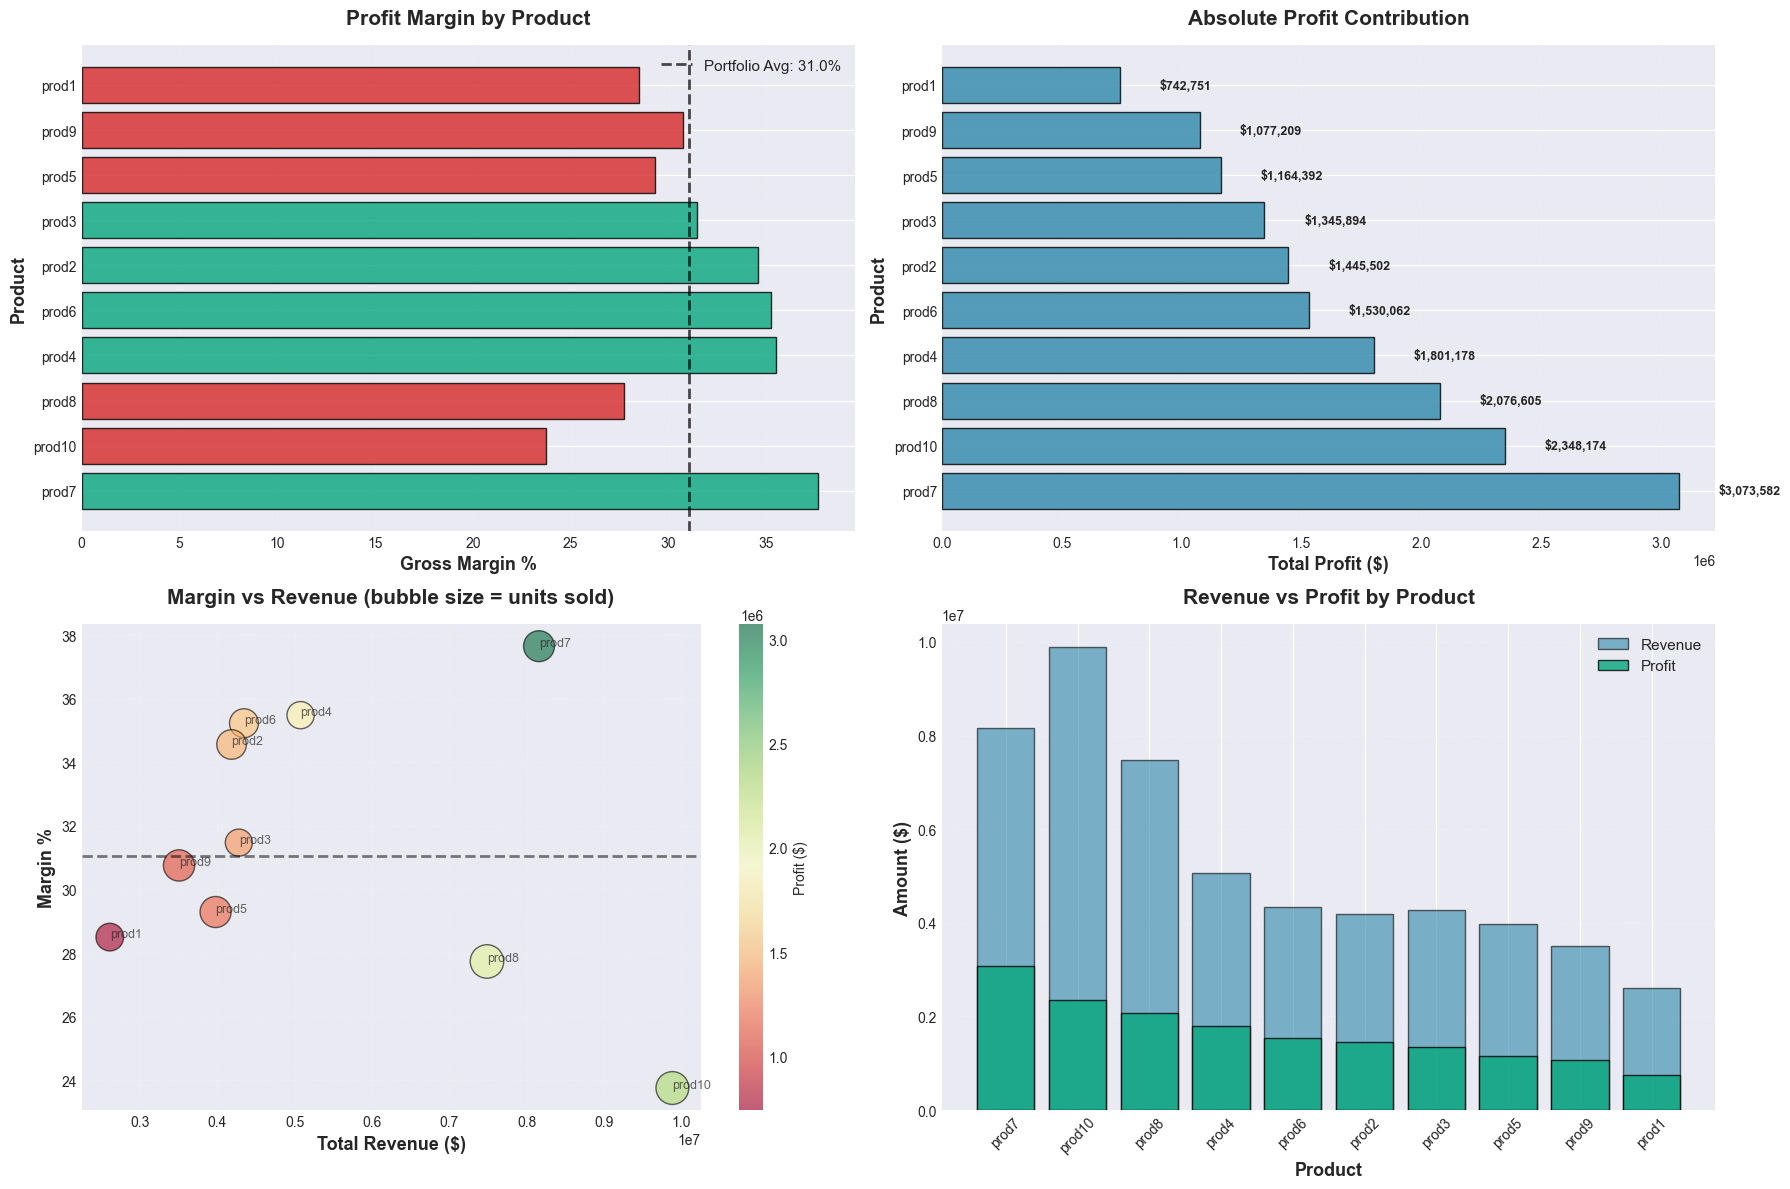

💾 Saved: 04_margin_optimization_study/01_margin_analysis.png


In [6]:
# Visualization 1: Margin Analysis Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Margin % by product
colors = [COLORS['success'] if m >= portfolio_margin else COLORS['danger'] for m in product_summary['margin_pct']]
ax1.barh(product_summary['product_id'], product_summary['margin_pct'],
         color=colors, edgecolor='black', linewidth=1, alpha=0.8)
ax1.axvline(portfolio_margin, color='black', linestyle='--', linewidth=2,
            label=f'Portfolio Avg: {portfolio_margin:.1f}%', alpha=0.7)
ax1.set_xlabel('Gross Margin %', fontsize=13, fontweight='bold')
ax1.set_ylabel('Product', fontsize=13, fontweight='bold')
ax1.set_title('Profit Margin by Product', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle=':', axis='x')

# Top-right: Absolute profit contribution
ax2.barh(product_summary['product_id'], product_summary['profit'],
         color=COLORS['primary'], edgecolor='black', linewidth=1, alpha=0.8)
ax2.set_xlabel('Total Profit ($)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Product', fontsize=13, fontweight='bold')
ax2.set_title('Absolute Profit Contribution', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle=':', axis='x')

# Add value labels
for i, (idx, row) in enumerate(product_summary.iterrows()):
    ax2.text(row['profit'] + total_profit*0.01, i, f"${row['profit']:,.0f}",
            va='center', fontsize=9, fontweight='bold')

# Bottom-left: Margin vs Revenue scatter
scatter = ax3.scatter(product_summary['total_revenue'], product_summary['margin_pct'],
                      s=product_summary['units_sold']*2, alpha=0.6,
                      c=product_summary['profit'], cmap='RdYlGn',
                      edgecolor='black', linewidth=1)
ax3.axhline(portfolio_margin, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_xlabel('Total Revenue ($)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Margin %', fontsize=13, fontweight='bold')
ax3.set_title('Margin vs Revenue (bubble size = units sold)', fontsize=15, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, linestyle=':')
plt.colorbar(scatter, ax=ax3, label='Profit ($)')

# Add product labels
for idx, row in product_summary.iterrows():
    ax3.annotate(row['product_id'], (row['total_revenue'], row['margin_pct']),
                fontsize=9, alpha=0.7)

# Bottom-right: Revenue vs Profit waterfall
revenue_bars = ax4.bar(product_summary['product_id'], product_summary['total_revenue'],
                       label='Revenue', color=COLORS['primary'], alpha=0.6, edgecolor='black')
profit_bars = ax4.bar(product_summary['product_id'], product_summary['profit'],
                      label='Profit', color=COLORS['success'], alpha=0.8, edgecolor='black')
ax4.set_xlabel('Product', fontsize=13, fontweight='bold')
ax4.set_ylabel('Amount ($)', fontsize=13, fontweight='bold')
ax4.set_title('Revenue vs Profit by Product', fontsize=15, fontweight='bold', pad=15)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, linestyle=':', axis='y')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_margin_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/01_margin_analysis.png")

## 2. Price vs Cost Structure

Analyzing the relationship between pricing and costs:
- Average selling price vs cost per unit
- Price variability
- Cost efficiency opportunities

In [7]:
# Calculate unit economics
product_summary['unit_profit'] = product_summary['avg_price'] - product_summary['avg_cost']
product_summary['markup_pct'] = ((product_summary['avg_price'] / product_summary['avg_cost']) - 1) * 100

print("Unit Economics Analysis:")
print("=" * 90)
print(f"{'Product':<12} {'Avg Price':<12} {'Avg Cost':<12} {'Unit Profit':<12} {'Markup %':<10}")
print("=" * 90)
for idx, row in product_summary.iterrows():
    print(f"{row['product_id']:<12} ${row['avg_price']:>9,.2f} ${row['avg_cost']:>9,.2f} ${row['unit_profit']:>9,.2f} {row['markup_pct']:>8.1f}%")

# Portfolio averages
avg_portfolio_price = product_summary['total_revenue'].sum() / product_summary['units_sold'].sum()
avg_portfolio_cost = product_summary['total_cost'].sum() / product_summary['units_sold'].sum()
avg_portfolio_markup = ((avg_portfolio_price / avg_portfolio_cost) - 1) * 100

print("\n" + "=" * 90)
print(f"{'PORTFOLIO AVG':<12} ${avg_portfolio_price:>9,.2f} ${avg_portfolio_cost:>9,.2f} ${avg_portfolio_price - avg_portfolio_cost:>9,.2f} {avg_portfolio_markup:>8.1f}%")
print("=" * 90)

# Find pricing opportunities
low_markup_products = product_summary[product_summary['markup_pct'] < avg_portfolio_markup].sort_values('total_revenue', ascending=False)
high_cost_products = product_summary.nlargest(3, 'avg_cost')

print(f"\n💡 PRICING OPPORTUNITIES:")
print(f"   • Portfolio average markup: {avg_portfolio_markup:.1f}%")
print(f"   • Products below average markup: {len(low_markup_products)}")
if len(low_markup_products) > 0:
    print(f"   • Top revenue products with low markup:")
    for idx, row in low_markup_products.head(3).iterrows():
        print(f"      - {row['product_id']}: {row['markup_pct']:.1f}% markup (${row['total_revenue']:,.0f} revenue)")
        potential_profit = row['units_sold'] * (row['avg_cost'] * (avg_portfolio_markup/100))
        profit_increase = potential_profit - row['profit']
        print(f"        → If raised to {avg_portfolio_markup:.1f}% markup: +${profit_increase:,.0f} profit")

Unit Economics Analysis:
Product      Avg Price    Avg Cost     Unit Profit  Markup %  
prod7        $32,908.14 $20,514.67 $12,393.48     60.4%
prod10       $35,438.95 $27,022.55 $ 8,416.39     31.1%
prod8        $25,730.95 $18,594.85 $ 7,136.10     38.4%
prod4        $26,434.01 $17,052.87 $ 9,381.14     55.0%
prod6        $20,011.29 $12,960.31 $ 7,050.98     54.4%
prod2        $18,422.58 $12,054.73 $ 6,367.85     52.8%
prod3        $22,505.63 $15,421.98 $ 7,083.65     45.9%
prod5        $15,901.21 $11,243.64 $ 4,657.57     41.4%
prod9        $13,788.41 $ 9,547.43 $ 4,240.98     44.4%
prod1        $13,095.97 $ 9,363.55 $ 3,732.42     39.9%

PORTFOLIO AVG $22,793.28 $15,718.14 $ 7,075.14     45.0%

💡 PRICING OPPORTUNITIES:
   • Portfolio average markup: 45.0%
   • Products below average markup: 5
   • Top revenue products with low markup:
      - prod10: 31.1% markup ($9,887,466 revenue)
        → If raised to 45.0% markup: +$1,045,455 profit
      - prod8: 38.4% markup ($7,487,707 reve

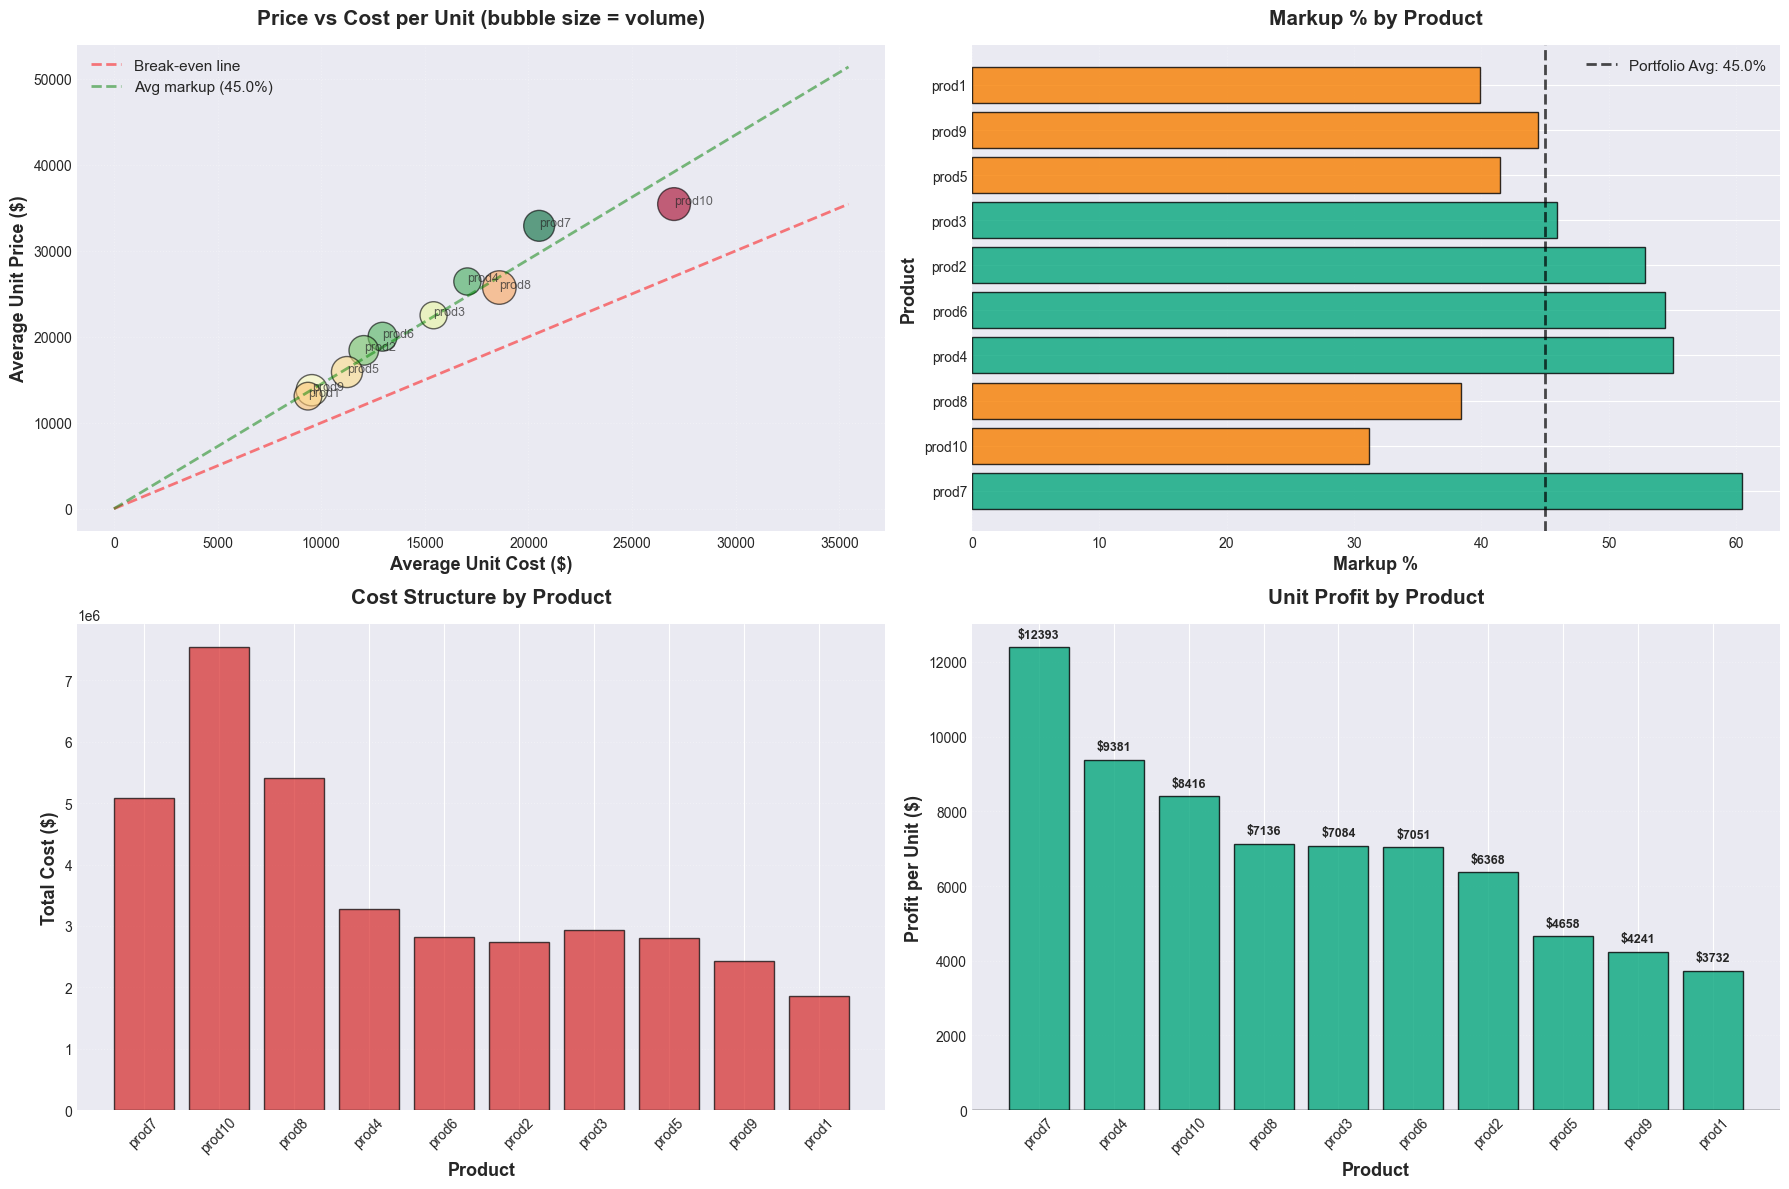

💾 Saved: 04_margin_optimization_study/02_price_cost_analysis.png


In [8]:
# Visualization 2: Price vs Cost Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Price vs Cost scatter
ax1.scatter(product_summary['avg_cost'], product_summary['avg_price'],
           s=product_summary['units_sold']*2, alpha=0.6,
           c=product_summary['margin_pct'], cmap='RdYlGn',
           edgecolor='black', linewidth=1)

# Add diagonal line (price = cost)
max_val = max(product_summary['avg_price'].max(), product_summary['avg_cost'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Break-even line', alpha=0.5)

# Add average markup line
ax1.plot([0, max_val], [0, max_val * (1 + avg_portfolio_markup/100)], 'g--',
        linewidth=2, label=f'Avg markup ({avg_portfolio_markup:.1f}%)', alpha=0.5)

ax1.set_xlabel('Average Unit Cost ($)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Average Unit Price ($)', fontsize=13, fontweight='bold')
ax1.set_title('Price vs Cost per Unit (bubble size = volume)', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle=':')

for idx, row in product_summary.iterrows():
    ax1.annotate(row['product_id'], (row['avg_cost'], row['avg_price']),
                fontsize=9, alpha=0.7)

# Top-right: Markup % distribution
colors_markup = [COLORS['success'] if m >= avg_portfolio_markup else COLORS['warning'] for m in product_summary['markup_pct']]
ax2.barh(product_summary['product_id'], product_summary['markup_pct'],
         color=colors_markup, edgecolor='black', linewidth=1, alpha=0.8)
ax2.axvline(avg_portfolio_markup, color='black', linestyle='--', linewidth=2,
            label=f'Portfolio Avg: {avg_portfolio_markup:.1f}%', alpha=0.7)
ax2.set_xlabel('Markup %', fontsize=13, fontweight='bold')
ax2.set_ylabel('Product', fontsize=13, fontweight='bold')
ax2.set_title('Markup % by Product', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle=':', axis='x')

# Bottom-left: Cost breakdown
cost_breakdown = product_summary[['product_id', 'total_cost', 'avg_cost']].copy()
ax3.bar(cost_breakdown['product_id'], cost_breakdown['total_cost'],
        color=COLORS['danger'], edgecolor='black', linewidth=1, alpha=0.7)
ax3.set_xlabel('Product', fontsize=13, fontweight='bold')
ax3.set_ylabel('Total Cost ($)', fontsize=13, fontweight='bold')
ax3.set_title('Cost Structure by Product', fontsize=15, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, linestyle=':', axis='y')
ax3.tick_params(axis='x', rotation=45)

# Bottom-right: Unit profit waterfall
product_summary_sorted = product_summary.sort_values('unit_profit', ascending=False)
colors_profit = [COLORS['success'] if up > 0 else COLORS['danger'] for up in product_summary_sorted['unit_profit']]
ax4.bar(product_summary_sorted['product_id'], product_summary_sorted['unit_profit'],
        color=colors_profit, edgecolor='black', linewidth=1, alpha=0.8)
ax4.axhline(0, color='black', linewidth=1)
ax4.set_xlabel('Product', fontsize=13, fontweight='bold')
ax4.set_ylabel('Profit per Unit ($)', fontsize=13, fontweight='bold')
ax4.set_title('Unit Profit by Product', fontsize=15, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, linestyle=':', axis='y')
ax4.tick_params(axis='x', rotation=45)

for i, (idx, row) in enumerate(product_summary_sorted.iterrows()):
    ax4.text(i, row['unit_profit'] + (product_summary_sorted['unit_profit'].max()*0.02),
            f"${row['unit_profit']:.0f}", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_price_cost_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/02_price_cost_analysis.png")

## 3. Margin Evolution Over Time

Tracking how margins change over the analysis period:
- Daily margin trends
- Product-level margin stability
- Cost inflation detection

In [9]:
# Calculate daily margins
df_daily['profit'] = df_daily['price_total_sum'] - df_daily['cost_total_sum']
df_daily['margin_pct'] = (df_daily['profit'] / df_daily['price_total_sum']) * 100
df_daily = df_daily.sort_values('dt_date')

print("Daily Margin Evolution:")
print("=" * 80)
print(f"{'Date':<15} {'Revenue':<15} {'Cost':<15} {'Profit':<15} {'Margin %':<10}")
print("=" * 80)
for idx, row in df_daily.head(10).iterrows():
    print(f"{row['dt_date'].strftime('%Y-%m-%d'):<15} ${row['price_total_sum']:>12,.0f} ${row['cost_total_sum']:>12,.0f} ${row['profit']:>12,.0f} {row['margin_pct']:>8.1f}%")

# Calculate margin trend
margin_trend = stats.linregress(range(len(df_daily)), df_daily['margin_pct'])
margin_change_per_day = margin_trend.slope
margin_change_total = margin_change_per_day * len(df_daily)

print(f"\n📈 MARGIN TREND:")
print(f"   • Starting margin: {df_daily.iloc[0]['margin_pct']:.1f}%")
print(f"   • Ending margin: {df_daily.iloc[-1]['margin_pct']:.1f}%")
print(f"   • Daily change: {margin_change_per_day:+.3f} percentage points/day")
print(f"   • Total change: {margin_change_total:+.1f} percentage points over period")
print(f"   • Average margin: {df_daily['margin_pct'].mean():.1f}%")
print(f"   • Margin volatility: {df_daily['margin_pct'].std():.1f}% std dev")

if margin_change_per_day > 0.01:
    print(f"   ✅ Margins are IMPROVING over time")
elif margin_change_per_day < -0.01:
    print(f"   ⚠️ Margins are DECLINING - investigate cost increases or pricing pressure")
else:
    print(f"   ➡️ Margins are STABLE")

Daily Margin Evolution:
Date            Revenue         Cost            Profit          Margin %  
2025-10-01      $   1,740,701 $   1,085,435 $     655,266     37.6%
2025-10-02      $   2,455,105 $   1,429,106 $   1,025,999     41.8%
2025-10-03      $   2,732,750 $   1,876,081 $     856,669     31.3%
2025-10-04      $   2,294,542 $   1,453,574 $     840,968     36.7%
2025-10-05      $   1,366,127 $     941,393 $     424,734     31.1%
2025-10-06      $     599,110 $     895,889 $    -296,779    -49.5%
2025-10-07      $   1,192,244 $     751,192 $     441,052     37.0%
2025-10-08      $     919,648 $     615,279 $     304,369     33.1%
2025-10-09      $   2,123,168 $   1,430,065 $     693,103     32.6%
2025-10-10      $   2,159,223 $   1,280,582 $     878,641     40.7%

📈 MARGIN TREND:
   • Starting margin: 37.6%
   • Ending margin: 26.7%
   • Daily change: +0.154 percentage points/day
   • Total change: +4.6 percentage points over period
   • Average margin: 29.0%
   • Margin volatilit

In [10]:
# Product-level margin trends
df_products['profit'] = df_products['price_total_sum'] - df_products['cost_total_sum']
df_products['margin_pct'] = (df_products['profit'] / df_products['price_total_sum']) * 100
df_products = df_products.sort_values('dt_date')

# Calculate margin trend for each product
product_margin_trends = []
for product in df_products['in_product_id'].unique():
    product_data = df_products[df_products['in_product_id'] == product].sort_values('dt_date')
    if len(product_data) > 5:  # Need enough data points
        trend = stats.linregress(range(len(product_data)), product_data['margin_pct'])
        product_margin_trends.append({
            'product_id': product,
            'margin_trend': trend.slope,
            'avg_margin': product_data['margin_pct'].mean(),
            'margin_volatility': product_data['margin_pct'].std(),
            'starting_margin': product_data.iloc[0]['margin_pct'],
            'ending_margin': product_data.iloc[-1]['margin_pct']
        })

margin_trends_df = pd.DataFrame(product_margin_trends)

print(f"\nProduct Margin Trends:")
for idx, row in margin_trends_df.iterrows():
    direction = "↑" if row['margin_trend'] > 0 else "↓" if row['margin_trend'] < 0 else "→"
    print(f"   {row['product_id']}: {direction} {row['margin_trend']:+.3f} pp/day (avg: {row['avg_margin']:.1f}%)")


Product Margin Trends:
   prod1: ↓ -1.185 pp/day (avg: -5.6%)
   prod8: ↑ +6.014 pp/day (avg: -1.7%)
   prod7: ↑ +1.444 pp/day (avg: -38.2%)
   prod6: ↓ -2.730 pp/day (avg: 4.6%)
   prod5: ↓ -1.614 pp/day (avg: 0.3%)
   prod4: ↑ +5.664 pp/day (avg: -10.6%)
   prod3: ↓ -6.404 pp/day (avg: -5.0%)
   prod2: ↓ -2.086 pp/day (avg: -3.2%)
   prod9: ↑ +0.164 pp/day (avg: 30.2%)
   prod10: ↓ -1.125 pp/day (avg: 20.8%)


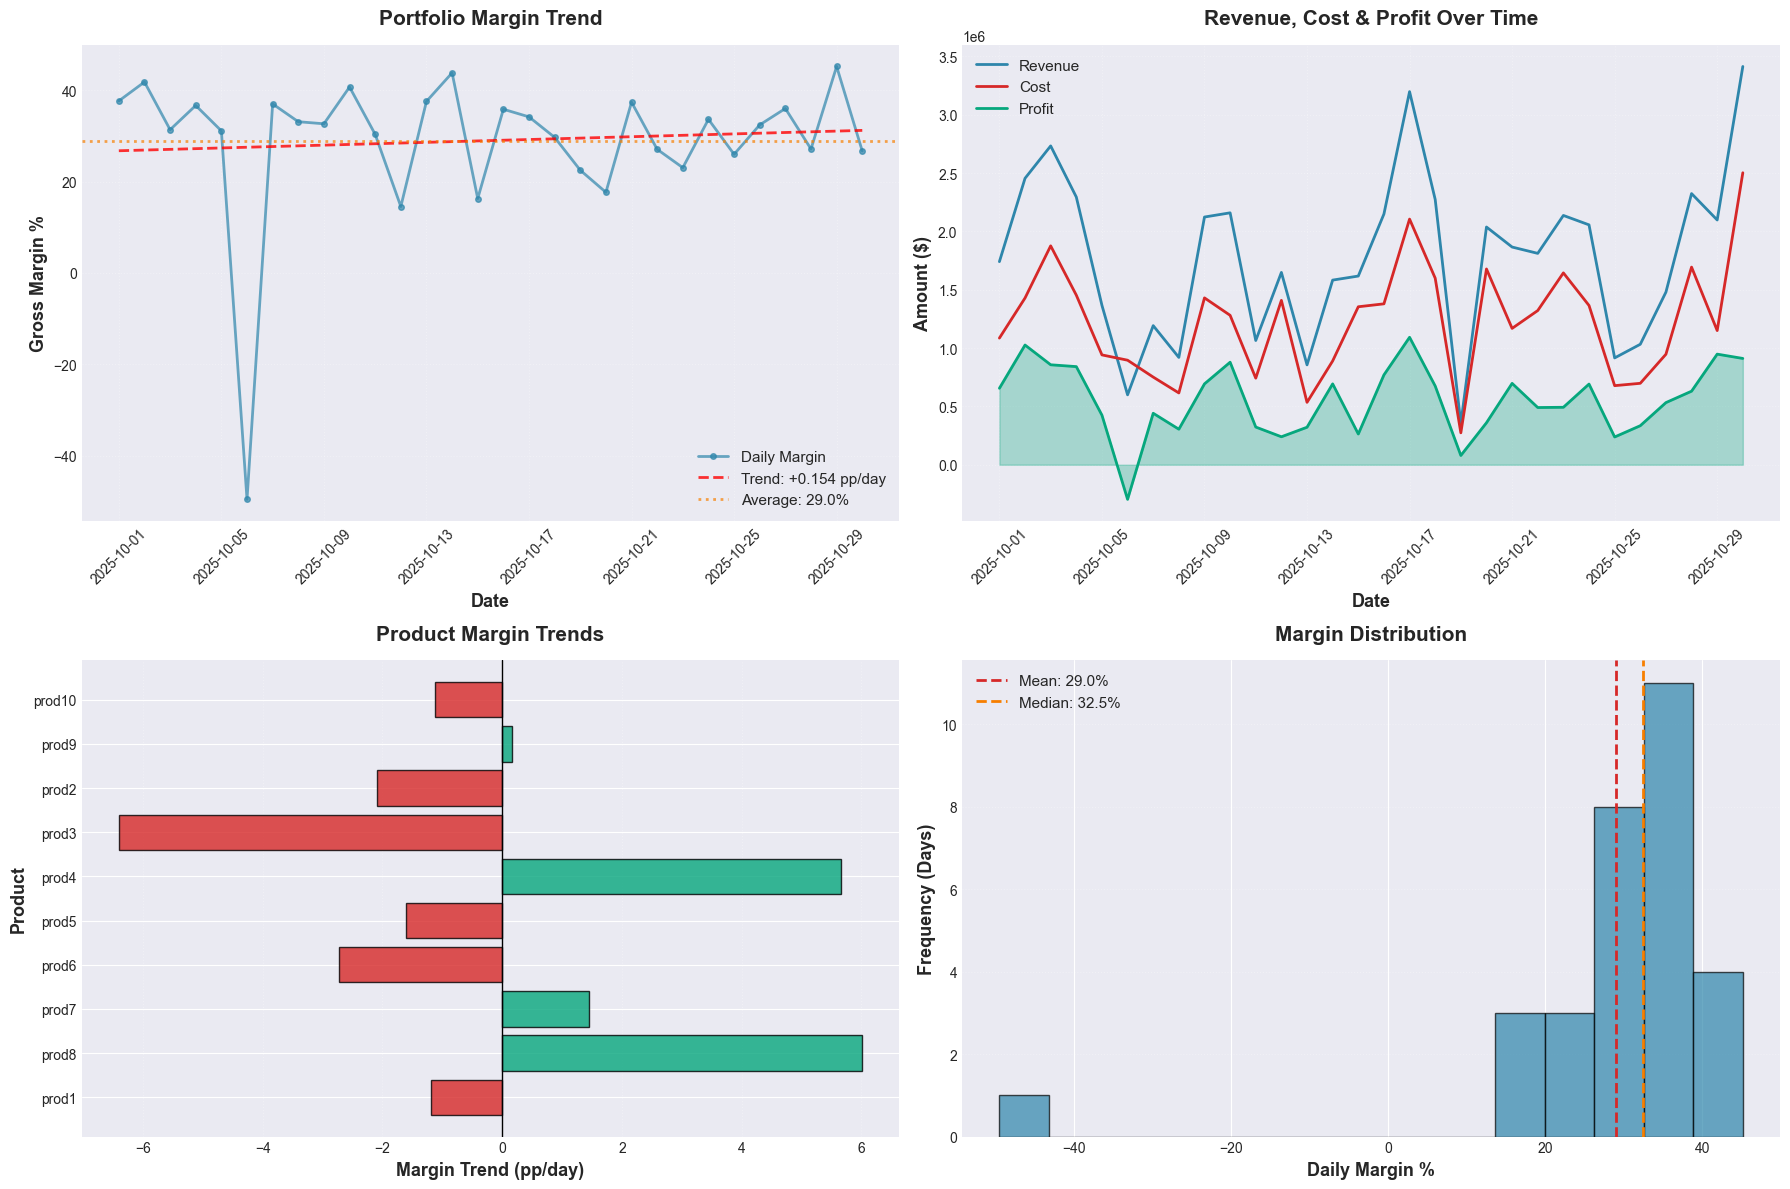

💾 Saved: 04_margin_optimization_study/03_margin_trends.png


In [11]:
# Visualization 3: Margin Trends Over Time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Daily margin trend
ax1.plot(df_daily['dt_date'], df_daily['margin_pct'],
        color=COLORS['primary'], linewidth=2, marker='o', markersize=4, alpha=0.7, label='Daily Margin')

# Add trend line
z = np.polyfit(range(len(df_daily)), df_daily['margin_pct'], 1)
p = np.poly1d(z)
ax1.plot(df_daily['dt_date'], p(range(len(df_daily))),
        'r--', linewidth=2, label=f'Trend: {z[0]:+.3f} pp/day', alpha=0.8)

ax1.axhline(df_daily['margin_pct'].mean(), color=COLORS['warning'], linestyle=':',
           linewidth=2, label=f'Average: {df_daily["margin_pct"].mean():.1f}%', alpha=0.7)

ax1.set_xlabel('Date', fontsize=13, fontweight='bold')
ax1.set_ylabel('Gross Margin %', fontsize=13, fontweight='bold')
ax1.set_title('Portfolio Margin Trend', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.tick_params(axis='x', rotation=45)

# Top-right: Revenue, Cost, Profit stacked area
ax2.plot(df_daily['dt_date'], df_daily['price_total_sum'], linewidth=2, label='Revenue', color=COLORS['primary'])
ax2.plot(df_daily['dt_date'], df_daily['cost_total_sum'], linewidth=2, label='Cost', color=COLORS['danger'])
ax2.plot(df_daily['dt_date'], df_daily['profit'], linewidth=2, label='Profit', color=COLORS['success'])
ax2.fill_between(df_daily['dt_date'], df_daily['profit'], alpha=0.3, color=COLORS['success'])

ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
ax2.set_ylabel('Amount ($)', fontsize=13, fontweight='bold')
ax2.set_title('Revenue, Cost & Profit Over Time', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.tick_params(axis='x', rotation=45)

# Bottom-left: Product margin trends
if len(margin_trends_df) > 0:
    colors_trends = [COLORS['success'] if t > 0 else COLORS['danger'] if t < 0 else COLORS['secondary']
                    for t in margin_trends_df['margin_trend']]
    ax3.barh(margin_trends_df['product_id'], margin_trends_df['margin_trend'],
            color=colors_trends, edgecolor='black', linewidth=1, alpha=0.8)
    ax3.axvline(0, color='black', linewidth=1)
    ax3.set_xlabel('Margin Trend (pp/day)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Product', fontsize=13, fontweight='bold')
    ax3.set_title('Product Margin Trends', fontsize=15, fontweight='bold', pad=15)
    ax3.grid(True, alpha=0.3, linestyle=':', axis='x')

# Bottom-right: Margin distribution histogram
ax4.hist(df_daily['margin_pct'], bins=15, color=COLORS['primary'],
        edgecolor='black', alpha=0.7)
ax4.axvline(df_daily['margin_pct'].mean(), color=COLORS['danger'],
           linestyle='--', linewidth=2, label=f"Mean: {df_daily['margin_pct'].mean():.1f}%")
ax4.axvline(df_daily['margin_pct'].median(), color=COLORS['warning'],
           linestyle='--', linewidth=2, label=f"Median: {df_daily['margin_pct'].median():.1f}%")

ax4.set_xlabel('Daily Margin %', fontsize=13, fontweight='bold')
ax4.set_ylabel('Frequency (Days)', fontsize=13, fontweight='bold')
ax4.set_title('Margin Distribution', fontsize=15, fontweight='bold', pad=15)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, linestyle=':', axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_margin_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/03_margin_trends.png")

## 4. Margin Improvement Scenarios

Modeling potential profit increases from margin optimization:
- Price increase scenarios
- Cost reduction opportunities
- Product mix optimization

In [12]:
# Scenario modeling
scenarios = []

# Baseline
baseline_profit = product_summary['profit'].sum()
scenarios.append({'scenario': 'Baseline (Current)', 'profit': baseline_profit, 'change': 0})

# Scenario 1: 5% price increase across all products
scenario1_revenue = product_summary['total_revenue'].sum() * 1.05
scenario1_profit = scenario1_revenue - product_summary['total_cost'].sum()
scenarios.append({
    'scenario': '5% Price Increase (All Products)',
    'profit': scenario1_profit,
    'change': scenario1_profit - baseline_profit
})

# Scenario 2: 10% cost reduction across all products
scenario2_cost = product_summary['total_cost'].sum() * 0.90
scenario2_profit = product_summary['total_revenue'].sum() - scenario2_cost
scenarios.append({
    'scenario': '10% Cost Reduction (All Products)',
    'profit': scenario2_profit,
    'change': scenario2_profit - baseline_profit
})

# Scenario 3: Bring low-margin products up to portfolio average
scenario3_profit = 0
for idx, row in product_summary.iterrows():
    if row['margin_pct'] < portfolio_margin:
        # Calculate profit if this product had portfolio average margin
        target_profit = row['total_revenue'] * (portfolio_margin / 100)
        scenario3_profit += target_profit
    else:
        scenario3_profit += row['profit']
scenarios.append({
    'scenario': 'Raise Low-Margin to Avg',
    'profit': scenario3_profit,
    'change': scenario3_profit - baseline_profit
})

# Scenario 4: 3% price increase + 5% cost reduction
scenario4_revenue = product_summary['total_revenue'].sum() * 1.03
scenario4_cost = product_summary['total_cost'].sum() * 0.95
scenario4_profit = scenario4_revenue - scenario4_cost
scenarios.append({
    'scenario': '3% Price + 5% Cost Reduction',
    'profit': scenario4_profit,
    'change': scenario4_profit - baseline_profit
})

# Scenario 5: Optimize product mix (prioritize high-margin products)
# Simulate 20% shift from low-margin to high-margin products
high_margin_products = product_summary[product_summary['margin_pct'] > portfolio_margin]
low_margin_products = product_summary[product_summary['margin_pct'] <= portfolio_margin]
shift_amount = low_margin_products['total_revenue'].sum() * 0.20
avg_high_margin = high_margin_products['margin_pct'].mean() / 100
avg_low_margin = low_margin_products['margin_pct'].mean() / 100
scenario5_profit = baseline_profit + (shift_amount * avg_high_margin) - (shift_amount * avg_low_margin)
scenarios.append({
    'scenario': 'Product Mix Optimization',
    'profit': scenario5_profit,
    'change': scenario5_profit - baseline_profit
})

scenarios_df = pd.DataFrame(scenarios)

print("Margin Improvement Scenarios:")
print("=" * 90)
print(f"{'Scenario':<40} {'Total Profit':<20} {'Profit Increase':<20}")
print("=" * 90)
for idx, row in scenarios_df.iterrows():
    if row['change'] == 0:
        print(f"{row['scenario']:<40} ${row['profit']:>16,.0f}    ---")
    else:
        pct_change = (row['change'] / baseline_profit) * 100
        print(f"{row['scenario']:<40} ${row['profit']:>16,.0f}    +${row['change']:>12,.0f} (+{pct_change:.1f}%)")
print("=" * 90)

best_scenario = scenarios_df[scenarios_df['change'] > 0].nlargest(1, 'change').iloc[0]
print(f"\n🎯 BEST OPPORTUNITY: {best_scenario['scenario']}")
print(f"   Potential profit increase: +${best_scenario['change']:,.0f} (+{(best_scenario['change']/baseline_profit)*100:.1f}%)")

Margin Improvement Scenarios:
Scenario                                 Total Profit         Profit Increase     
Baseline (Current)                       $      16,605,349    ---
5% Price Increase (All Products)         $      19,280,140    +$   2,674,791 (+16.1%)
10% Cost Reduction (All Products)        $      20,294,396    +$   3,689,047 (+22.2%)
Raise Low-Margin to Avg                  $      17,719,565    +$   1,114,216 (+6.7%)
3% Price + 5% Cost Reduction             $      20,054,747    +$   3,449,398 (+20.8%)
Product Mix Optimization                 $      16,983,116    +$     377,767 (+2.3%)

🎯 BEST OPPORTUNITY: 10% Cost Reduction (All Products)
   Potential profit increase: +$3,689,047 (+22.2%)


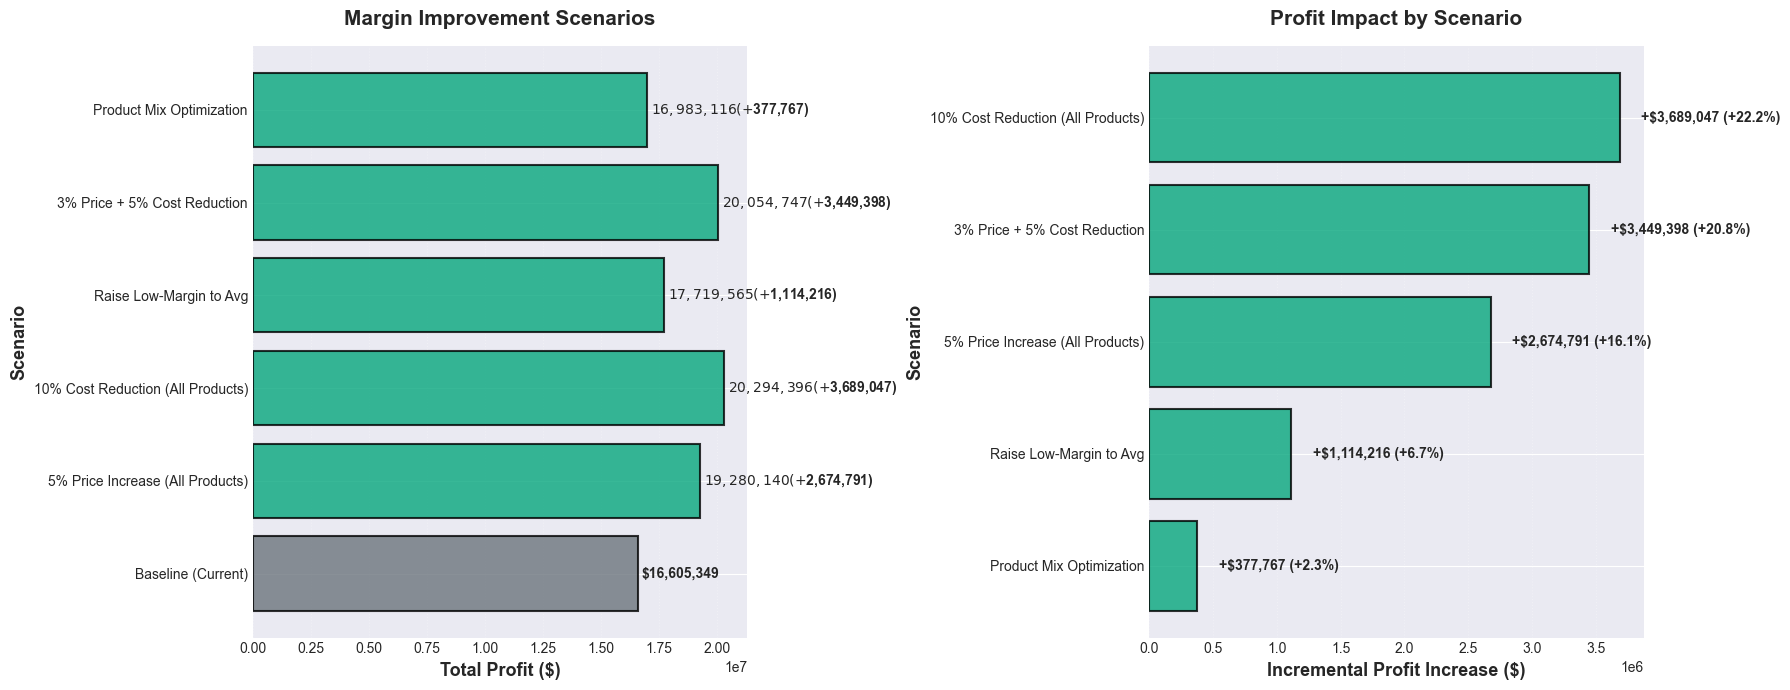

💾 Saved: 04_margin_optimization_study/04_scenario_analysis.png


In [13]:
# Visualization 4: Scenario Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left: Scenario comparison
colors_scenario = [COLORS['secondary'] if s == 'Baseline (Current)' else COLORS['success']
                  for s in scenarios_df['scenario']]
bars = ax1.barh(scenarios_df['scenario'], scenarios_df['profit'],
               color=colors_scenario, edgecolor='black', linewidth=1.5, alpha=0.8)

ax1.set_xlabel('Total Profit ($)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Scenario', fontsize=13, fontweight='bold')
ax1.set_title('Margin Improvement Scenarios', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle=':', axis='x')

# Add value labels
for i, (idx, row) in enumerate(scenarios_df.iterrows()):
    label = f"${row['profit']:,.0f}"
    if row['change'] > 0:
        label += f" (+${row['change']:,.0f})"
    ax1.text(row['profit'] + baseline_profit*0.01, i, label,
            va='center', fontsize=10, fontweight='bold')

# Right: Incremental profit from scenarios
scenarios_incremental = scenarios_df[scenarios_df['change'] > 0].sort_values('change', ascending=True)
ax2.barh(scenarios_incremental['scenario'], scenarios_incremental['change'],
        color=COLORS['success'], edgecolor='black', linewidth=1.5, alpha=0.8)

ax2.set_xlabel('Incremental Profit Increase ($)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Scenario', fontsize=13, fontweight='bold')
ax2.set_title('Profit Impact by Scenario', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle=':', axis='x')

# Add percentage labels
for i, (idx, row) in enumerate(scenarios_incremental.iterrows()):
    pct = (row['change'] / baseline_profit) * 100
    ax2.text(row['change'] + baseline_profit*0.01, i,
            f"+${row['change']:,.0f} (+{pct:.1f}%)",
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_scenario_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/04_scenario_analysis.png")

## 5. Strategic Recommendations

Actionable insights for margin optimization

In [14]:
print("="*100)
print("STRATEGIC RECOMMENDATIONS: MARGIN OPTIMIZATION")
print("="*100)

print(f"\n📊 PORTFOLIO OVERVIEW:")
print(f"   • Current portfolio margin: {portfolio_margin:.1f}%")
print(f"   • Total profit: ${total_profit:,.0f}")
print(f"   • Average markup: {avg_portfolio_markup:.1f}%")
print(f"   • Margin volatility: {df_daily['margin_pct'].std():.1f}% std dev")

print(f"\n🎯 PRICING OPPORTUNITIES:")
low_markup_count = len(product_summary[product_summary['markup_pct'] < avg_portfolio_markup])
print(f"   • {low_markup_count} products below average markup")
if len(low_markup_products) > 0:
    top_opportunity = low_markup_products.iloc[0]
    potential_increase = top_opportunity['units_sold'] * (top_opportunity['avg_cost'] * (avg_portfolio_markup/100)) - top_opportunity['profit']
    print(f"   • Top opportunity: {top_opportunity['product_id']}")
    print(f"      - Current markup: {top_opportunity['markup_pct']:.1f}%")
    print(f"      - If raised to average: +${potential_increase:,.0f} profit")
    print(f"      - High volume (${top_opportunity['total_revenue']:,.0f} revenue) = high impact")

print(f"\n💰 COST MANAGEMENT:")
total_cost = product_summary['total_cost'].sum()
cost_10pct_reduction = total_cost * 0.10
print(f"   • Total cost base: ${total_cost:,.0f}")
print(f"   • 10% cost reduction opportunity: +${cost_10pct_reduction:,.0f} profit")
high_cost = product_summary.nlargest(3, 'total_cost')
print(f"   • Focus on top 3 cost products:")
for idx, row in high_cost.iterrows():
    print(f"      - {row['product_id']}: ${row['total_cost']:,.0f} total cost ({(row['total_cost']/total_cost)*100:.1f}% of total)")

print(f"\n📈 MARGIN TRENDS:")
if margin_change_per_day > 0.01:
    print(f"   ✅ Margins improving at {margin_change_per_day:+.3f} pp/day")
    print(f"   • Continue current pricing and cost management strategies")
elif margin_change_per_day < -0.01:
    print(f"   ⚠️ Margins declining at {margin_change_per_day:.3f} pp/day")
    print(f"   • URGENT: Investigate cost increases or pricing pressure")
    print(f"   • Consider price adjustments to maintain margins")
else:
    print(f"   ➡️ Margins stable")
    print(f"   • Opportunity to test price increases")

if len(margin_trends_df) > 0:
    declining_products = margin_trends_df[margin_trends_df['margin_trend'] < -0.01]
    if len(declining_products) > 0:
        print(f"   • {len(declining_products)} products with declining margins:")
        for idx, row in declining_products.iterrows():
            print(f"      - {row['product_id']}: {row['margin_trend']:.3f} pp/day decline")

print(f"\n🚀 QUICK WINS:")
print(f"   1. Price optimization: {best_scenario['scenario']}")
print(f"      → Potential: +${best_scenario['change']:,.0f} profit (+{(best_scenario['change']/baseline_profit)*100:.1f}%)")
print(f"   2. Focus on high-margin products")
if len(high_margin_products) > 0:
    top_margin = high_margin_products.iloc[0]
    print(f"      → Promote {top_margin['product_id']} ({top_margin['margin_pct']:.1f}% margin)")
print(f"   3. Improve or phase out low-margin products")
low_margin = product_summary[product_summary['margin_pct'] < portfolio_margin * 0.7]
if len(low_margin) > 0:
    print(f"      → {len(low_margin)} products below 70% of average margin")
    for idx, row in low_margin.iterrows():
        print(f"         - {row['product_id']}: {row['margin_pct']:.1f}% margin (${row['total_revenue']:,.0f} revenue)")

print(f"\n💡 STRATEGIC ACTIONS:")
print(f"   • SHORT-TERM (0-3 months):")
print(f"      - Implement 3-5% price increase on products below average markup")
print(f"      - Negotiate cost reductions with top 3 suppliers")
print(f"      - A/B test pricing on high-volume products")
print(f"   • MEDIUM-TERM (3-6 months):")
print(f"      - Shift marketing spend to high-margin products")
print(f"      - Review and optimize cost structure")
print(f"      - Implement dynamic pricing for volatile products")
print(f"   • LONG-TERM (6-12 months):")
print(f"      - Phase out consistently low-margin products")
print(f"      - Develop premium product lines with higher margins")
print(f"      - Implement margin monitoring dashboard")

print("\n" + "="*100)

STRATEGIC RECOMMENDATIONS: MARGIN OPTIMIZATION

📊 PORTFOLIO OVERVIEW:
   • Current portfolio margin: 31.0%
   • Total profit: $16,605,349
   • Average markup: 45.0%
   • Margin volatility: 16.7% std dev

🎯 PRICING OPPORTUNITIES:
   • 5 products below average markup
   • Top opportunity: prod10
      - Current markup: 31.1%
      - If raised to average: +$1,045,455 profit
      - High volume ($9,887,466 revenue) = high impact

💰 COST MANAGEMENT:
   • Total cost base: $36,890,471
   • 10% cost reduction opportunity: +$3,689,047 profit
   • Focus on top 3 cost products:
      - prod10: $7,539,292 total cost (20.4% of total)
      - prod8: $5,411,102 total cost (14.7% of total)
      - prod7: $5,087,637 total cost (13.8% of total)

📈 MARGIN TRENDS:
   ✅ Margins improving at +0.154 pp/day
   • Continue current pricing and cost management strategies
   • 6 products with declining margins:
      - prod1: -1.185 pp/day decline
      - prod6: -2.730 pp/day decline
      - prod5: -1.614 pp/day d

In [15]:
print("\n✅ MARGIN OPTIMIZATION STUDY COMPLETE!")
print(f"\nAll visualizations saved to: {OUTPUT_DIR}/")
print("  1. 01_margin_analysis.png")
print("  2. 02_price_cost_analysis.png")
print("  3. 03_margin_trends.png")
print("  4. 04_scenario_analysis.png")
print("\n📊 Key Findings:")
print(f"  • Portfolio margin: {portfolio_margin:.1f}%")
print(f"  • Best margin product: {best_margin_product['product_id']} ({best_margin_product['margin_pct']:.1f}%)")
print(f"  • Worst margin product: {worst_margin_product['product_id']} ({worst_margin_product['margin_pct']:.1f}%)")
print(f"  • Margin trend: {margin_change_per_day:+.3f} pp/day")
print(f"  • Best scenario: {best_scenario['scenario']} (+${best_scenario['change']:,.0f})")


✅ MARGIN OPTIMIZATION STUDY COMPLETE!

All visualizations saved to: 04_margin_optimization_study/
  1. 01_margin_analysis.png
  2. 02_price_cost_analysis.png
  3. 03_margin_trends.png
  4. 04_scenario_analysis.png

📊 Key Findings:
  • Portfolio margin: 31.0%
  • Best margin product: prod7 (37.7%)
  • Worst margin product: prod10 (23.7%)
  • Margin trend: +0.154 pp/day
  • Best scenario: 10% Cost Reduction (All Products) (+$3,689,047)
